In [1]:
import torch
import math

from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
            

The goal of this project is to implement a deep network such that, given as input a series of 2×14×14 tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is lesser or equal to the second.

The training and test set should be 1, 000 pairs each, and the size of the images allows to run experiments rapidly, even in the VM with a single core and no GPU.


You can generate the data sets to use with the function generate_pair_sets(N) defined in the file dlc_practical_prologue.py.

In [3]:
import dlc_practical_prologue

In [4]:
train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(100)

c:\users\guilhem\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\users\guilhem\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\users\guilhem\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\users\guilhem\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


|      Name     | Tensor Dimension |   Type  |                  Content                 |
|:-------------:|:----------------:|:-------:|:----------------------------------------:|
|  Train_input  |  N x 2 x 14 x 14 | float32 |                  Images                  |
|  Train_target |         N        |  int64  |          Class to predict €{0,1}         |
| Train_classes |       N x 2      |  int64  | Classes of the two digits € {0, ... ,9 } |
|   Test_input  |  N x 2 x 14 x 14 | float32 |                  Images                  |
|  Test_target  |         N        |  int64  |          Class to predict €{0,1}         |
|  Test_classes |       N x 2      |  int64  | Classes of the two digits € {0, ... ,9 } |

The goal of the project is to compare different architectures, and assess the performance improvement that can be achieved through weight sharing, or using auxiliary losses.

For the latter, the training can in particular take advantage of the availability of the classes of the two digits in each pair, beside the Boolean value truly of interest.

All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000 parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error rate.

Performance estimates provided in your report should be estimated through 10+ rounds for each architecture, where both data and weight initialization are randomized, and you should provide estimates of standard deviations.


In [5]:
train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable(train_classes)
test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)
mini_batch_size = 100


In [6]:
def train_model(model, train_input, train_target):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = 1e-1)
    nb_epochs = 25

    for e in range(nb_epochs):
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()


In [7]:
def compute_nb_errors(model, data_input, data_target):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1)
        for k in range(mini_batch_size):
            if data_target.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

In [8]:
class Weight_Sharing_Model(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        """Modele 1 for digit recognition"""
        self.Layer1 = nn.Linear(196, nb_hidden)
        self.Layer2 = nn.Linear(nb_hidden, 10)
        self.Boolean_Comparison = nn.Linear(20, 1)

        """Modele 2 for digit comparison"""
    def forward(self,img1,img2):
        x = F.relu(self.Layer1(img1.view(-1, 196)))
        x = self.Layer2(x)
        y = F.relu(self.Layer1(img1.view(-1, 196)))
        y = self.Layer2(y)
        z=self.Boolean_Comparison(torch.cat((x,y)).view(-1, 20))
        """y = F.relu(F.max_pool2d(self.conv1(img2), kernel_size=3, stride=3))
        y = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        y = F.relu(self.fc1(x.view(-1, 256)))
        y = self.fc2(x)
        z=self.Boolean_Comparison()"""
        return x,y,z

In [9]:
LOLOLO = train_input.view(200,14,14) #Tout les images se suivent

In [13]:
im = LOLOLO[101] # pour vérifier on prend la 102ème au pif

In [14]:
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()
img = to_pil(im)
import matplotlib.pyplot as plt

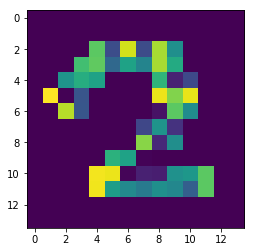

In [15]:
plt.imshow(img) # tada !